# Foundations Of AIML
## Session 11
### Experiment 2.1: Fine-tuning pre-trained CNN

We have seen using the pre-trained model as a black box for feature extraction. This gave us a decent accuracy. However, if we have sufficent data we can *tweak* the learned model to extract features specific to our new dataset. Note that, we have 5000 training images which is not sufficient to train a deep model from scratch. But, 5000 might be enough to *tweak* the pre-trained model to be specific to our dataset. We will see what happens when we tweak only a small specific part of the pre-trained model. We will also see how to tweak the entire model. How many layers to tweak depends on amount of available data. Finetuning to specific data, when done properly, is almost always beneficial.

In [0]:
# Importing pytorch packages
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
# Importing config.py file
import config as cf
from utils import *
from light_cnn import network_9layers
from data_loader import *
## Importing python packages
import os
import sys
import time
import datetime
import numpy as np
import math
import matplotlib.pyplot as plt

In [0]:
img_root = cf.data_dir+'IMFDB_final/'

train_list_file = cf.data_dir+'IMFDB_train.txt'   #### 5000 images for training
val_list_file = cf.data_dir+'IMFDB_test.txt'      #### 1095 images for validation


train_image_list = [line.rstrip('\n') for line in open(train_list_file)]
val_image_list = [line.rstrip('\n') for line in open(val_list_file)]

print len(train_image_list), len(val_image_list)

trainloader = torch.utils.data.DataLoader(custom_data_loader(img_root = img_root, image_list = train_list_file, crop=False,
                                                             resize = True, resize_shape=[128,128]), 
                                           batch_size=32, num_workers=16, shuffle = True, pin_memory=True)

testloader = torch.utils.data.DataLoader(custom_data_loader(img_root = img_root, image_list = val_list_file, crop=False, mirror=False, 
                                                           resize = True, resize_shape=[128,128]), 
                                           batch_size=10, num_workers=5, shuffle = False, pin_memory=True)


classes = ['AamairKhan', 'Rimisen', 'Kajol', 'KareenaKapoor','RishiKapoor', 'AmrishPuri', 'AnilKapoor', 'AnupamKher', 'BomanIrani', 'HrithikRoshan', 'KajalAgarwal', 'KatrinaKaif', 'Madhavan', 'MadhuriDixit', 'Umashri', 'Trisha']

5000 1095


In [0]:
# Checking for GPU instance
use_cuda = torch.cuda.is_available()
#Intilizaing the accuracy value as zero
best_acc = 0
num_classes = 16

### Net surgery
the original pre-trained model has the last layer (fc2) for 79077 classes but we want to have last layer for only 16 classes.
We chop-off the fc2 with 79077 classes and *implant* a new classifier (the MLP model we used in the previous experiment) which predicts 16 classes. Note that we could also implant a single FC layer with 16 classes (instead of a 3 layer MLP).

In [0]:
feature_net = network_9layers()   ### creates an object of this network architecture
from collections import OrderedDict
new_state_dict = OrderedDict()
state_dict = torch.load(cf.data_dir+'light_cnn/LightCNN_9Layers_checkpoint.pth.tar')['state_dict']    ### load the learned lightCNN weights
for k, v in state_dict.items():
    name = k[7:] 
    new_state_dict[name] = v

feature_net.load_state_dict(new_state_dict)

### starting the surgery
layers_to_remove = ['fc2']
for layers_ in layers_to_remove:        
    del(feature_net._modules[layers_])
    
#### old fc2 removed.

classifier = nn.Sequential(nn.Linear(256, 64), nn.BatchNorm1d(64), nn.ReLU(),
                           nn.Linear(64, 32), nn.BatchNorm1d(32), nn.ReLU(),
                           nn.Linear(32, num_classes))

### implanting a new fc2
feature_net.fc2 = classifier
if use_cuda:
    feature_net.cuda()
    


In [0]:
### Intiliazing the loss
criterion = nn.CrossEntropyLoss()

In [0]:
def train(epoch):
    print('\nEpoch: %d' % epoch)
    feature_net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        optimizer.zero_grad()
        inputs, targets = Variable(inputs), Variable(targets)
        outputs = feature_net(inputs)      ### notice that the pre-trained network has an implant classifier which directly outputs the 16 class prediction scores

        
        size_ = outputs.size()
        outputs_ = outputs.view(size_[0], num_classes)
        loss = criterion(outputs_, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.data[0]
        _, predicted = torch.max(outputs_.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()
        
        if batch_idx%10 == 0 or batch_idx == len(trainloader)-1:
            progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                         % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
        
    train_loss_file.write('%d %.3f %.3f\n' %(epoch, train_loss/len(trainloader), 100.*correct/total))



In [0]:
def test(epoch):
    global best_acc
    feature_net.eval()
    test_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(testloader):
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        inputs, targets = Variable(inputs, volatile=True), Variable(targets)
        outputs = feature_net(inputs)
        size_ = outputs.size()
        outputs_ = outputs.view(size_[0], num_classes)
        loss = criterion(outputs_, targets)

        test_loss += loss.data[0]
        _, predicted = torch.max(outputs_.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()
        
        if batch_idx%10 == 0 or batch_idx == len(testloader)-1:
            progress_bar(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                         % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))
        
    print 'val_loss: ',  test_loss/len(testloader), 'accuracy: ', 100.0*correct/total
    val_loss_file.write('%d %.3f %.3f\n' %(epoch,  test_loss/len(testloader), 100.*correct/total))

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': classifier,
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir(cf.data_dir+'checkpoint'):
            os.mkdir(cf.data_dir+'checkpoint')
        torch.save(state, cf.data_dir+'checkpoint/checkpoint_ckpt.t7')
        best_acc = acc
    
    return test_loss/len(testloader)

In [0]:
experiment = 'lightnet_finetune_fc1_fc2_IMFDB'
train_loss_file = open(cf.data_dir+experiment+"train_loss.txt", "w", 0)
val_loss_file = open(cf.data_dir+experiment+"val_loss.txt", "w", 0)

In [0]:
### tweak only selected parts : FC1 and FC2. FC2 is 3 layer MLP.

layers_to_finetune = [{'params': feature_net.fc1.parameters()},
                      {'params':feature_net.fc2.parameters()}]

optimizer = optim.Adam(layers_to_finetune, lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2, verbose=True)   #### dynamic LR scheduler
for epoch in range(0, 30):
    train(epoch)
    test_loss = test(epoch)
    scheduler.step(test_loss)
    
train_loss_file.close()
val_loss_file.close()


Epoch: 0
 [==================================>] | Loss: 2.461 | Acc: 28.180% (1409/5000) 157/157 
 [==================================>] | Loss: 2.218 | Acc: 30.776% (337/1095)  110/110 
val_loss:  2.21792321855 accuracy:  30.7762557078
Saving..

Epoch: 1
 [==================================>] | Loss: 1.779 | Acc: 51.220% (2561/5000) 157/157 
 [==================================>] | Loss: 1.941 | Acc: 35.616% (390/1095)  110/110 
val_loss:  1.94056597298 accuracy:  35.6164383562
Saving..

Epoch: 2
 [==================================>] | Loss: 1.278 | Acc: 63.980% (3199/5000) 157/157 
 [==================================>] | Loss: 1.502 | Acc: 54.703% (599/1095)  110/110 
val_loss:  1.50216691982 accuracy:  54.703196347
Saving..

Epoch: 3
 [==================================>] | Loss: 0.989 | Acc: 72.520% (3626/5000) 157/157 
 [==================================>] | Loss: 1.265 | Acc: 58.721% (643/1095)  110/110 
val_loss:  1.26500773159 accuracy:  58.7214611872
Saving..

Epoch: 4
 [=

30 30


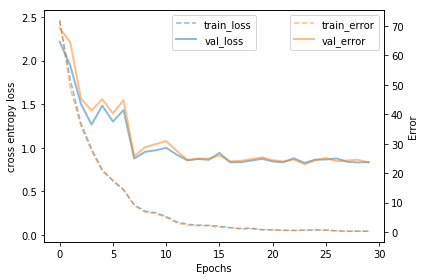

In [0]:
training_curves(cf.data_dir+experiment)

In [0]:
### After training we load the model that performed the best on validation data (avoid picking overfitted model)
classifier = torch.load(cf.data_dir+'checkpoint/checkpoint_ckpt.t7')['net'].eval()

In [0]:
def eval():
    feature_net.eval()
    
    testloader = torch.utils.data.DataLoader(custom_data_loader(img_root = img_root, image_list = val_list_file, crop=False, mirror=False, 
                                                           resize = True, resize_shape=[128,128]), 
                                           batch_size=1, num_workers=1, shuffle = False, pin_memory=True)
    correct = 0
    total = 0
    conf_mat = np.zeros((num_classes, num_classes))
    total_ = np.zeros((num_classes))
    wrong_predictions = []
    for batch_idx, (inputs, targets) in enumerate(testloader):
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        inputs, targets = Variable(inputs, volatile=True), Variable(targets)
        outputs = feature_net(inputs)
        size_ = outputs.size()
        outputs_ = outputs.view(size_[0], num_classes)
        _, predicted = torch.max(outputs_.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()
        prediction = predicted.cpu().numpy()[0]
        targets = targets.data.cpu().numpy()[0]
        total_[targets] +=1
        conf_mat[predicted, targets] +=1
        
        if prediction != targets:
            wrong_predictions += [[inputs, prediction, targets]]
        
    for k in range(num_classes):
        conf_mat[:,k] /= total_[k]
    return conf_mat, 100.*correct/total, wrong_predictions
    

In [0]:
conf, acc, wrong_predictions = eval()
print 'Accuracy:', acc, '%'

Whoa!! :o Fine-tuning improved the accuracy by more than 15%

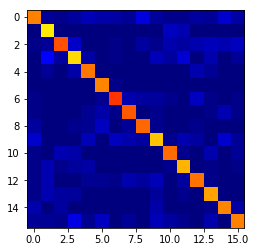

In [0]:
plt.imshow(conf, cmap='jet', vmin=0, vmax = 1)
plt.show()

AmrishPuri confused with AnupamKher


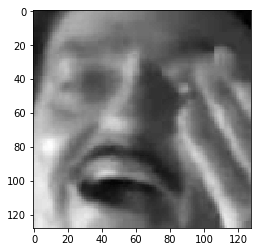

KareenaKapoor confused with Trisha


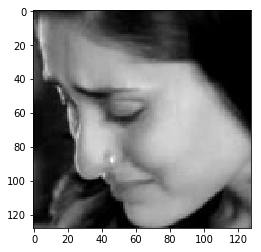

AnupamKher confused with BomanIrani


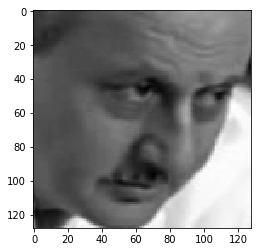

Rimisen confused with KareenaKapoor


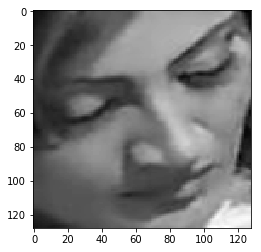

AnilKapoor confused with HrithikRoshan


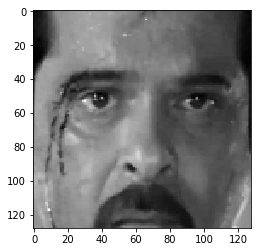

Kajol confused with KajalAgarwal


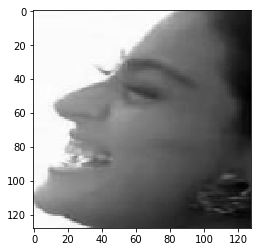

Rimisen confused with RishiKapoor


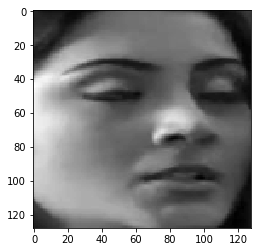

KareenaKapoor confused with Kajol


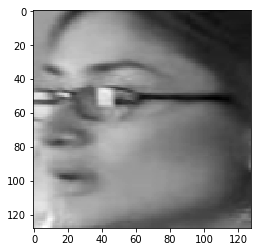

Kajol confused with Umashri


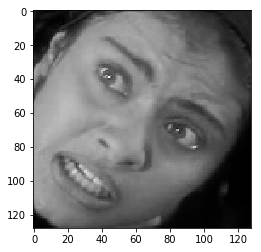

AnilKapoor confused with Kajol


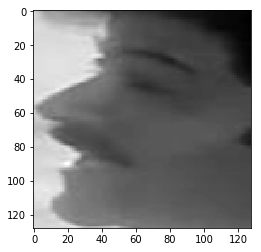

Trisha confused with KareenaKapoor


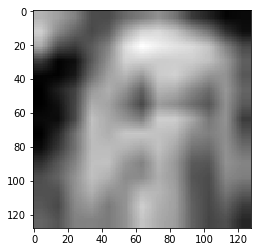

Madhavan confused with BomanIrani


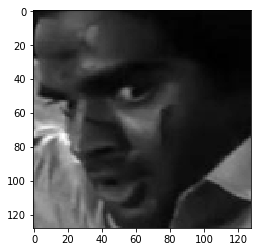

AmrishPuri confused with AnupamKher


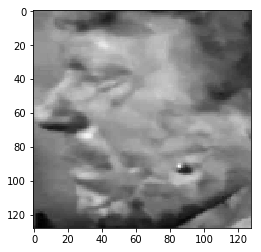

Trisha confused with AnupamKher


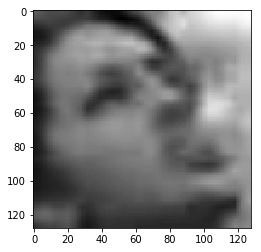

HrithikRoshan confused with Madhavan


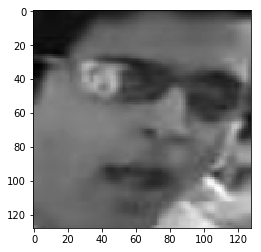

KareenaKapoor confused with Trisha


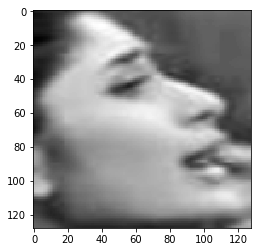

HrithikRoshan confused with Madhavan


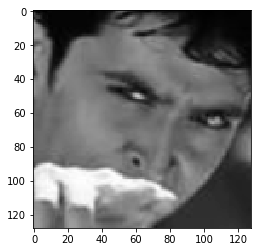

AnilKapoor confused with HrithikRoshan


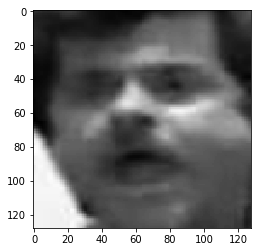

KareenaKapoor confused with KatrinaKaif


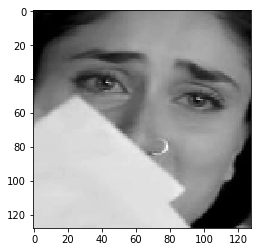

BomanIrani confused with HrithikRoshan


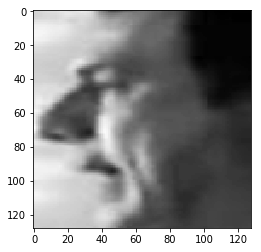

KatrinaKaif confused with Rimisen


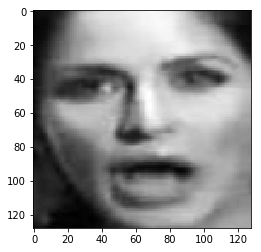

Rimisen confused with KareenaKapoor


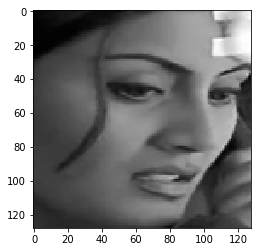

KajalAgarwal confused with Rimisen


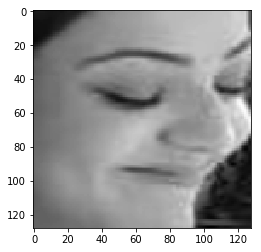

KajalAgarwal confused with AamairKhan


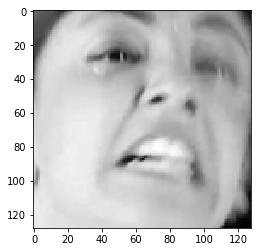

HrithikRoshan confused with MadhuriDixit


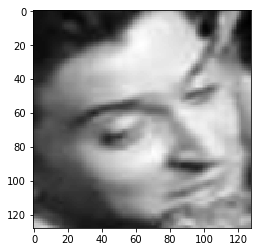

Umashri confused with AamairKhan


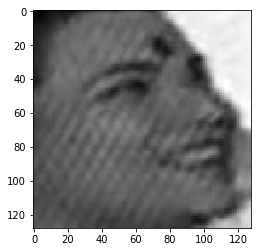

In [0]:
for w in wrong_predictions[::10]:
    print classes[w[2]], 'confused with', classes[w[1]]
    plt.imshow(w[0][0][0].data.cpu().numpy(), cmap='gray')
    plt.show()

### Now let's try fine-tuning all layers in the network

In [0]:
feature_net = network_9layers()
from collections import OrderedDict
new_state_dict = OrderedDict()
state_dict = torch.load(cf.data_dir+'light_cnn/LightCNN_9Layers_checkpoint.pth.tar')['state_dict']
for k, v in state_dict.items():
    name = k[7:] 
    new_state_dict[name] = v

feature_net.load_state_dict(new_state_dict)

layers_to_remove = ['fc2']
for layers_ in layers_to_remove:        
    del(feature_net._modules[layers_])
    


classifier = nn.Sequential(nn.Linear(256, 64), nn.BatchNorm1d(64), nn.ReLU(),
                           nn.Linear(64, 32), nn.BatchNorm1d(32), nn.ReLU(),
                           nn.Linear(32, num_classes))

feature_net.fc2 = classifier
if use_cuda:
    feature_net.cuda()

In [0]:
layers_to_finetune = [{'params': feature_net.features.parameters()}, 
                      {'params': feature_net.fc1.parameters()},
                      {'params':feature_net.fc2.parameters()}]

In [0]:
experiment = 'lightnet_finetune_all_IMFDB'
train_loss_file = open(cf.data_dir+experiment+"train_loss.txt", "w", 0)
val_loss_file = open(cf.data_dir+experiment+"val_loss.txt", "w", 0)

In [0]:
best_acc = 0
optimizer = optim.Adam(layers_to_finetune, lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2, verbose=True)   #### dynamic LR scheduler
for epoch in range(0, 30):
    train(epoch)
    test_loss = test(epoch)
    scheduler.step(test_loss)
    
train_loss_file.close()
val_loss_file.close()


Epoch: 0
 [==================================>] | Loss: 2.619 | Acc: 15.420% (771/5000)  157/157 
 [==================================>] | Loss: 2.589 | Acc: 15.068% (165/1095)  110/110 
val_loss:  2.5894901254 accuracy:  15.0684931507
Saving..

Epoch: 1
 [==================================>] | Loss: 2.263 | Acc: 30.120% (1506/5000) 157/157 
 [==================================>] | Loss: 2.120 | Acc: 34.612% (379/1095)  110/110 
val_loss:  2.11973307241 accuracy:  34.6118721461
Saving..

Epoch: 2
 [==================================>] | Loss: 1.850 | Acc: 43.640% (2182/5000) 157/157 
 [==================================>] | Loss: 1.681 | Acc: 47.032% (515/1095)  110/110 
val_loss:  1.68140776808 accuracy:  47.0319634703
Saving..

Epoch: 3
 [==================================>] | Loss: 1.474 | Acc: 55.560% (2778/5000) 157/157 
 [==================================>] | Loss: 1.500 | Acc: 52.785% (578/1095)  110/110 
val_loss:  1.50003729517 accuracy:  52.7853881279
Saving..

Epoch: 4
 [=

30 30


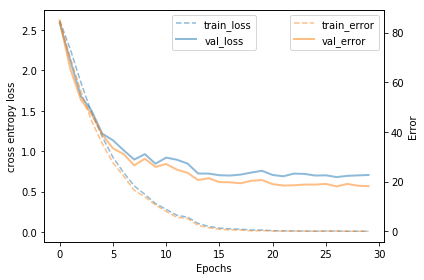

In [0]:
training_curves(cf.data_dir+experiment)

In [0]:
classifier = torch.load(cf.data_dir+'checkpoint/checkpoint_ckpt.t7')['net'].eval()

In [0]:
conf, acc, wrong_predictions = eval()
print 'Accuracy:', acc, '%'

Accuracy: 81.8264840183 %


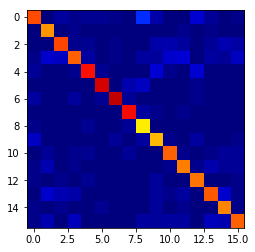

In [0]:
plt.imshow(conf, cmap='jet', vmin=0, vmax = 1)
plt.show()

HrithikRoshan confused with Madhavan


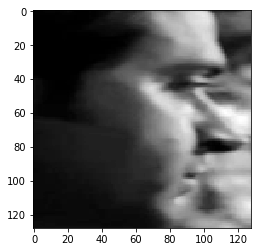

Kajol confused with MadhuriDixit


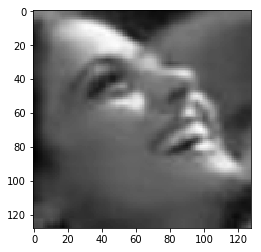

BomanIrani confused with AmrishPuri


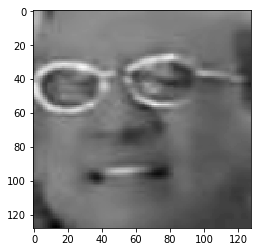

Trisha confused with KareenaKapoor


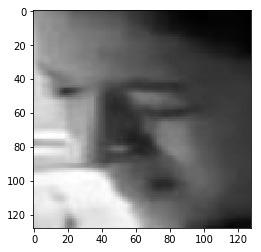

Kajol confused with Umashri


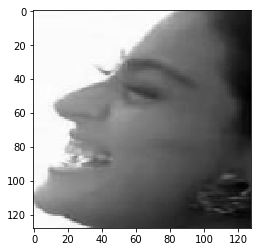

Rimisen confused with KareenaKapoor


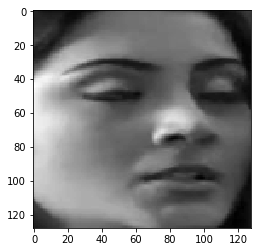

AamairKhan confused with AnilKapoor


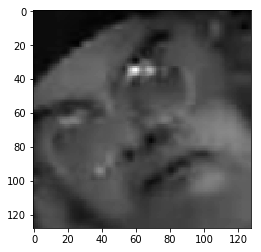

KatrinaKaif confused with Trisha


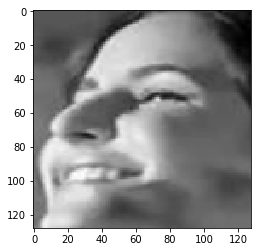

KatrinaKaif confused with KareenaKapoor


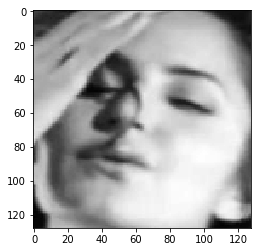

KareenaKapoor confused with MadhuriDixit


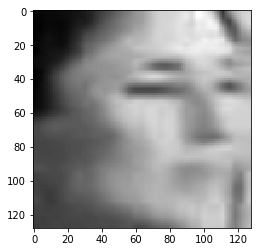

Madhavan confused with AamairKhan


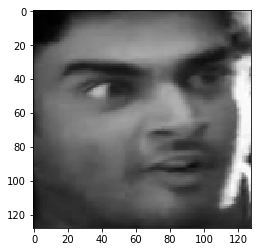

HrithikRoshan confused with Kajol


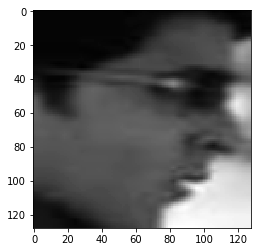

Kajol confused with AamairKhan


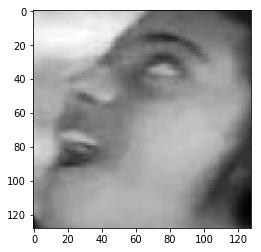

Trisha confused with KajalAgarwal


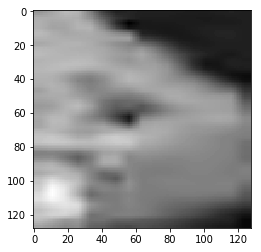

Madhavan confused with AamairKhan


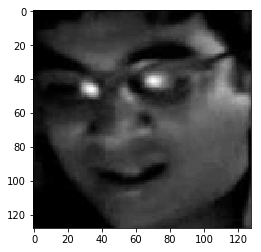

KareenaKapoor confused with MadhuriDixit


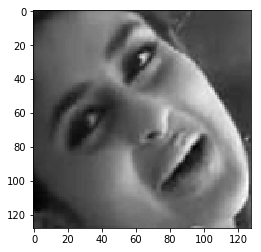

KatrinaKaif confused with KajalAgarwal


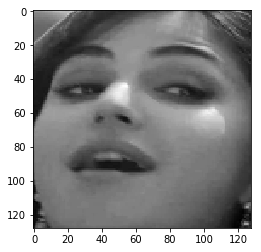

KajalAgarwal confused with Trisha


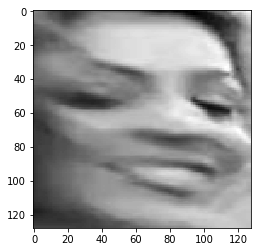

Umashri confused with KareenaKapoor


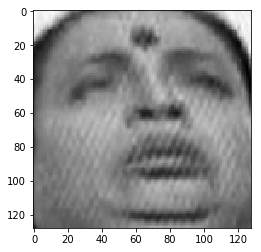

HrithikRoshan confused with AamairKhan


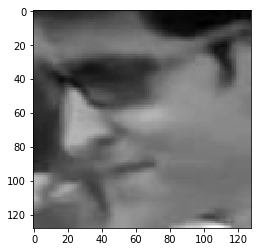

In [0]:
for w in wrong_predictions[::10]:
    print classes[w[2]], 'confused with', classes[w[1]]
    plt.imshow(w[0][0][0].data.cpu().numpy(), cmap='gray')
    plt.show()

Relying on pre-trained networks we improved the accuracy by more than 20%!!

### Different parts of the model can have different LR. While fine-tuning it is common to set the implanted layers to 10 times higher LR than pre-trained layers. This helps the implanted layers learns faster since it is starting from scratch.